In [ ]:
pip install torchinfo

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc
from torch.utils.data import Dataset, DataLoader
import re
import string
from collections import Counter
import math
import warnings
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer


warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


c:\Users\nandi\anaconda3\envs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


# Loading and Preprocessing Dataset

In [ ]:
#loading of data
def load_and_explore_data():
    train_df = pd.read_csv(r'.\ag_news_csv\train.csv', header=None, names=['label', 'title', 'description'])
    test_df = pd.read_csv(r'.\ag_news_csv\test.csv', header=None, names=['label', 'title', 'description'])

    with open(r'.\ag_news_csv\classes.txt', 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    print(f"Classes: {classes}")
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")

    train_df['text'] = train_df['title'].fillna('') + ' ' + train_df['description'].fillna('')
    test_df['text'] = test_df['title'].fillna('') + ' ' + test_df['description'].fillna('')
    train_df['label'] = train_df['label'] - 1
    test_df['label'] = test_df['label'] - 1

    return train_df, test_df, classes

train_df, test_df, classes = load_and_explore_data()


Classes: ['World', 'Sports', 'Business', 'Sci/Tech']
Training samples: 120000
Test samples: 7600


In [7]:
train_df.head()

,label,title,description,text
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   title        120000 non-null  object
 2   description  120000 non-null  object
 3   text         120000 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.7+ MB


In [6]:
train_df.describe()

,label
count,120000.000000
mean,1.500000
std,1.118039
min,0.000000
25%,0.750000
50%,1.500000
75%,2.250000
max,3.000000


In [7]:
print('\nDescriptive Statistics (Training):')
print(f'Number of training samples: {len(train_df)}')
print(f'Number of testing samples: {len(test_df)}')
class_dist = train_df['label'].value_counts(normalize=True) * 100
print('Class distribution (%):')
print(class_dist)

train_df['text_length_words'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['text_length_chars'] = train_df['text'].apply(lambda x: len(x))
print(f"Average text length (words): {train_df['text_length_words'].mean():.2f}")
print(f"Average text length (characters): {train_df['text_length_chars'].mean():.2f}")


Descriptive Statistics (Training):
Number of training samples: 120000
Number of testing samples: 7600
Class distribution (%):
label
2    25.0
3    25.0
1    25.0
0    25.0
Name: proportion, dtype: float64
Average text length (words): 37.42
Average text length (characters): 227.85


# Text Preprocessing

In [3]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# Visualizations

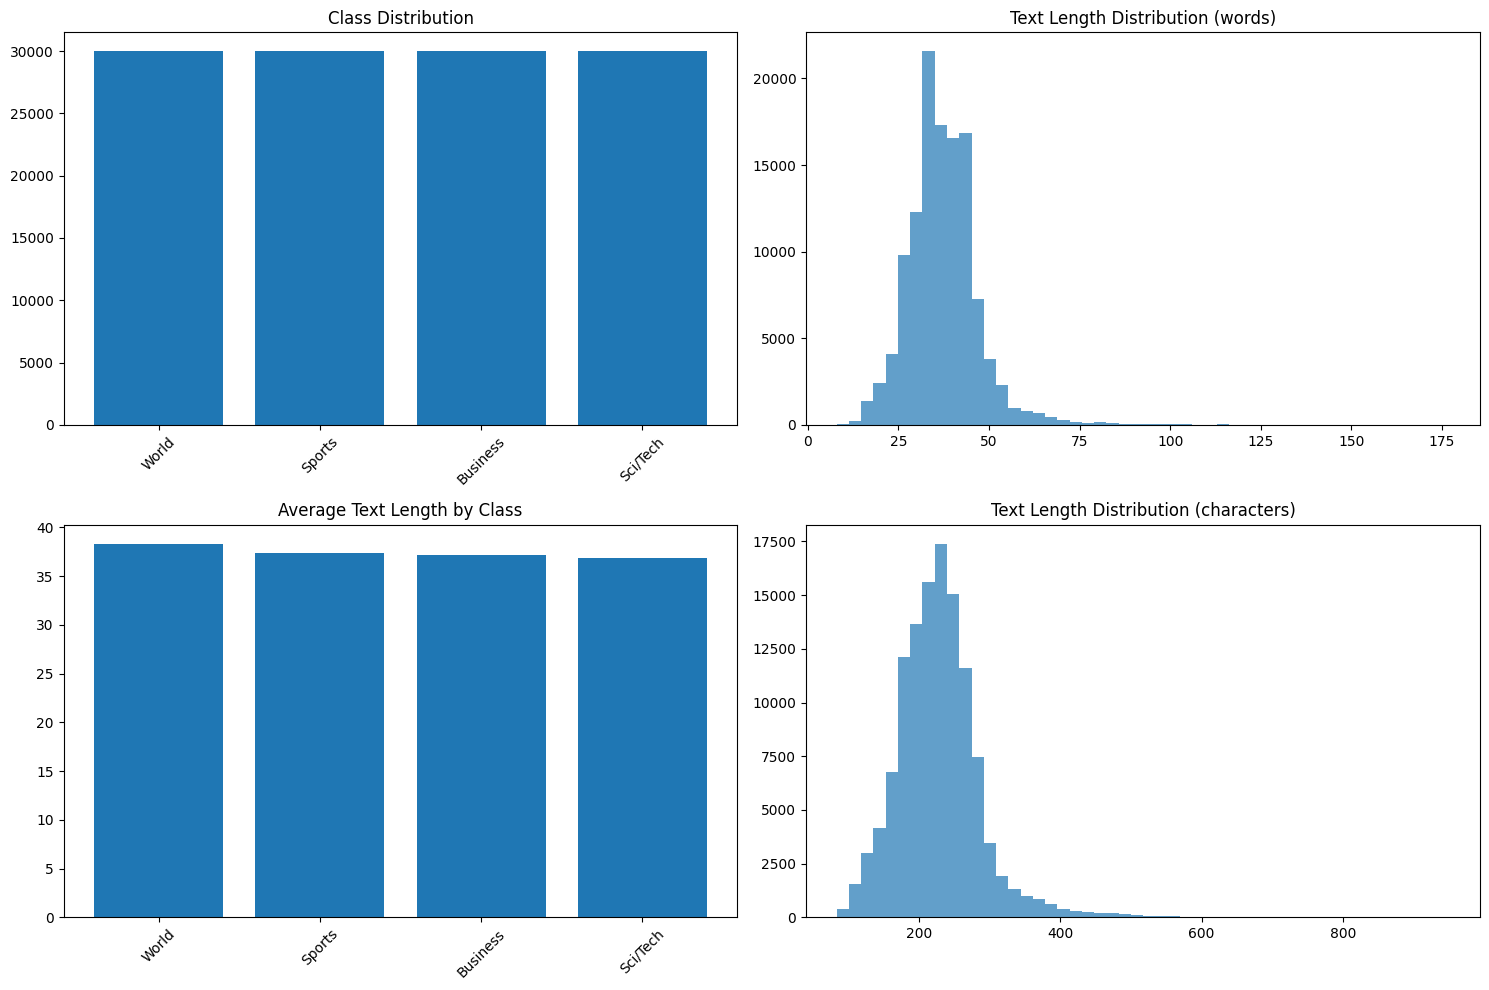


Dataset Statistics:
Samples: 120000
Avg text length: 37.42 words
Max: 177, Min: 8
95th percentile: 52


In [ ]:
#creating visualizations of data
def create_visualizations(train_df, classes):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    class_counts = train_df['label'].value_counts().sort_index()
    class_names = [classes[i] for i in class_counts.index]

    axes[0, 0].bar(class_names, class_counts.values)
    axes[0, 0].set_title('Class Distribution')
    axes[0, 0].tick_params(axis='x', rotation=45)

    text_lengths = train_df['text'].apply(lambda x: len(x.split()))
    axes[0, 1].hist(text_lengths, bins=50, alpha=0.7)
    axes[0, 1].set_title('Text Length Distribution (words)')

    avg_lengths = train_df.groupby('label')['text'].apply(lambda x: x.apply(lambda y: len(y.split())).mean())
    axes[1, 0].bar(range(len(classes)), avg_lengths.values)
    axes[1, 0].set_xticks(range(len(classes)))
    axes[1, 0].set_xticklabels(classes, rotation=45)
    axes[1, 0].set_title('Average Text Length by Class')

    char_lengths = train_df['text'].apply(len)
    axes[1, 1].hist(char_lengths, bins=50, alpha=0.7)
    axes[1, 1].set_title('Text Length Distribution (characters)')

    plt.tight_layout()
    plt.show()

    print("\nDataset Statistics:")
    print(f"Samples: {len(train_df)}")
    print(f"Avg text length: {text_lengths.mean():.2f} words")
    print(f"Max: {text_lengths.max()}, Min: {text_lengths.min()}")
    print(f"95th percentile: {text_lengths.quantile(0.95):.0f}")
create_visualizations(train_df, classes)


# Vocabulary Builder

In [ ]:
#vocabulary builder
def build_vocabulary(texts, min_freq=2, max_vocab_size=10000):
    word_freq = Counter()
    for text in texts:
        words = text.split()
        word_freq.update(words)

    most_common = word_freq.most_common(max_vocab_size - 4)
    vocab = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
    for word, freq in most_common:
        if freq >= min_freq:
            vocab[word] = len(vocab)

    print(f"Vocabulary size: {len(vocab)}")
    return vocab

vocab = build_vocabulary(train_df['text'].tolist())


Vocabulary size: 10000


# Text Dataset

In [ ]:
class TextDataset(Dataset):
  # to initialize the custom text dataset

    def __init__(self, texts, labels, vocab, max_length=512):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.text_to_tokens(text)

        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            tokens += [self.vocab['<PAD>']] * (self.max_length - len(tokens))

        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

   # to convert text to a list of token indices
    def text_to_tokens(self, text):
        tokens = text.split()
        return [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]


# Create Dataset and Dataloaders

In [ ]:
# Split into training and validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(), train_df['label'].tolist(),
    test_size=0.15, random_state=42, stratify=train_df['label']
)

# to set maximum token length and batch size
max_length = 256
batch_size = 32

#to create dataset objects for each split
train_dataset = TextDataset(train_texts, train_labels, vocab, max_length)
val_dataset = TextDataset(val_texts, val_labels, vocab, max_length)
test_dataset = TextDataset(test_df['text'].tolist(), test_df['label'].tolist(), vocab, max_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# summary of prepared DataLoaders
print("Dataloaders prepared:")
print(f"Train: {len(train_loader)} batches")
print(f"Val: {len(val_loader)} batches")
print(f"Test: {len(test_loader)} batches")


Dataloaders prepared:
Train: 3188 batches
Val: 563 batches
Test: 238 batches


# Building Model

In [ ]:
# PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):  # x: [batch_size, seq_len, d_model]
        return x + self.pe[:, :x.size(1)]


In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=8, num_layers=4,
                 d_ff=1024, max_len=256, num_classes=4, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)

        # PyTorch-native Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True  # important: keeps batch as first dim
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)  # [batch_size, seq_len, d_model]
        x = self.pos_encoder(x)                          # [batch_size, seq_len, d_model]
        x = self.transformer_encoder(x)                  # [batch_size, seq_len, d_model]
        x = x.mean(dim=1)                                # Global average pooling
        x = self.dropout(x)
        return self.classifier(x) 


# Training and Validation method creation

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

#training
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for data, targets in dataloader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == targets).sum().item()
        total += targets.size(0)
    return total_loss / len(dataloader), 100. * correct / total

#validation
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)
    return total_loss / len(dataloader), 100. * correct / total


# Training the model

In [ ]:
# Initialize model
model = TransformerClassifier(
    vocab_size=len(vocab),
    d_model=256,
    n_heads=8,
    n_layers=4,
    d_ff=1024,
    max_len=max_length,
    num_classes=len(classes),
    dropout=0.1
).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_stopper = EarlyStopping(patience=5)

num_epochs = 5
train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val_acc = 0.0

print("Training started...\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_transformer_model.pt')
        print("Best model saved")

    if early_stopper(val_loss):
        print("Early stopping is triggered.")
        break


Training started...


Epoch 1/5
Train Loss: 0.7604 | Train Acc: 76.95%
Val   Loss: 0.5370 | Val   Acc: 82.37%
Best model saved

Epoch 2/5
Train Loss: 0.4140 | Train Acc: 87.53%
Val   Loss: 0.3676 | Val   Acc: 88.39%
Best model saved

Epoch 3/5
Train Loss: 0.3369 | Train Acc: 89.21%
Val   Loss: 0.3261 | Val   Acc: 89.34%
Best model saved

Epoch 4/5
Train Loss: 0.2894 | Train Acc: 90.66%
Val   Loss: 0.3124 | Val   Acc: 89.94%
Best model saved

Epoch 5/5
Train Loss: 0.2575 | Train Acc: 91.65%
Val   Loss: 0.2997 | Val   Acc: 90.29%
Best model saved


# Plotting results

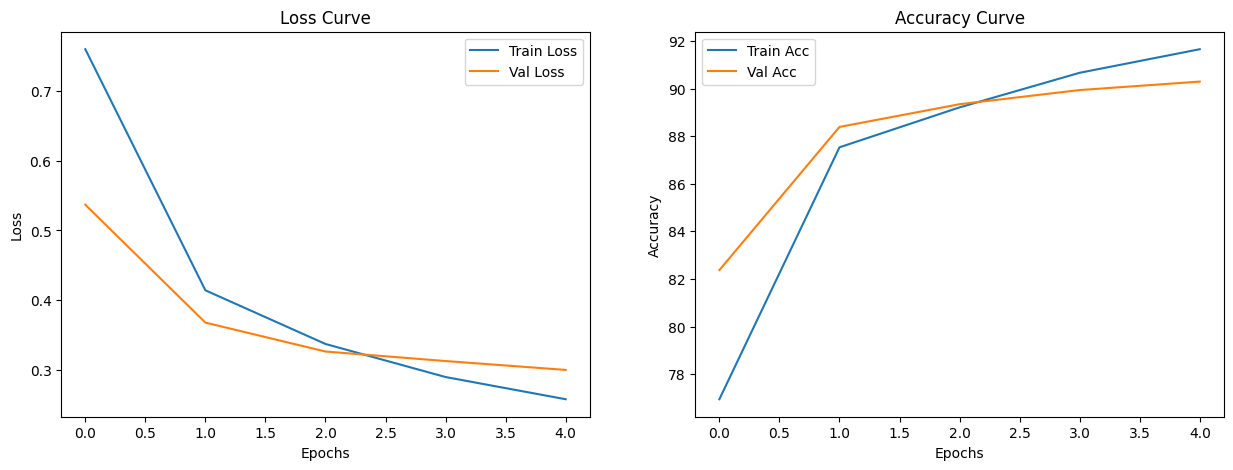

In [ ]:
#loss curve and accuracy curve plots
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title('Accuracy Curve')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_training_history(train_losses, val_losses, train_accs, val_accs)


# Evaluation

In [ ]:
#model evaluation
def evaluate_model(model, dataloader, device, classes):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    return accuracy, precision, recall, f1, all_preds, all_targets

# Load best model
model.load_state_dict(torch.load("best_transformer_model.pt"))

print("\nValidation Set Results:")
val_acc, val_prec, val_rec, val_f1, _, _ = evaluate_model(model, val_loader, device, classes)

print("\nTest Set Results:")
test_acc, test_prec, test_rec, test_f1, test_preds, test_targets = evaluate_model(model, test_loader, device, classes)



Validation Set Results:
Accuracy : 0.9029
Precision: 0.9047
Recall   : 0.9029
F1 Score : 0.9028

Test Set Results:
Accuracy : 0.8964
Precision: 0.8986
Recall   : 0.8964
F1 Score : 0.8966


# Confusion Matrix and ROC curve

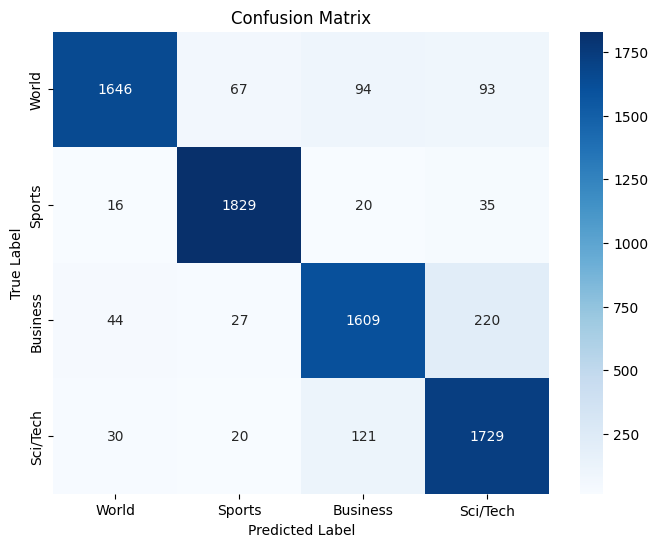

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


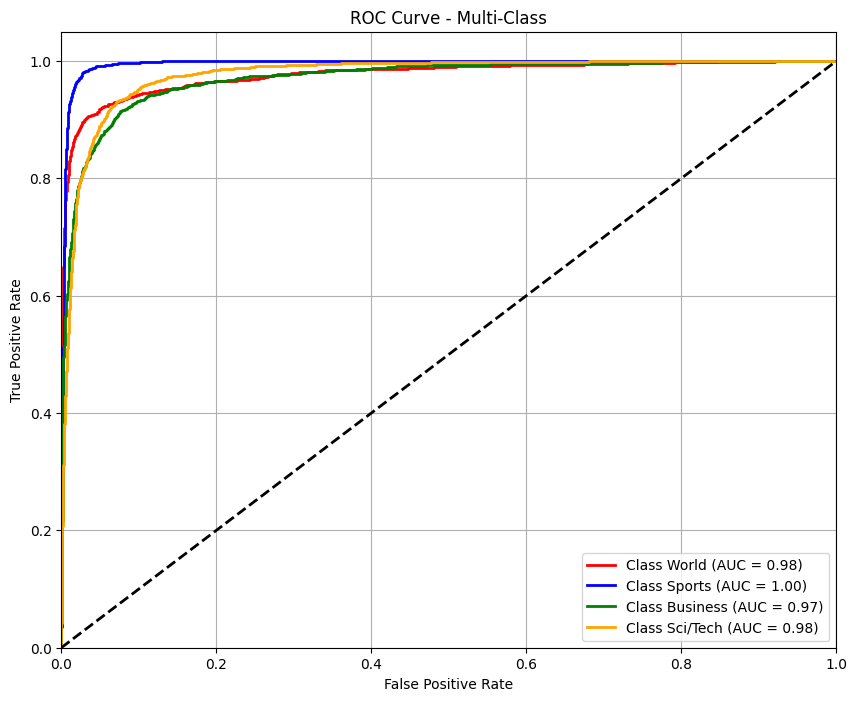

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
y_test_bin = label_binarize(test_targets, classes=range(len(classes)))

# Get softmax probabilities
model.eval()
all_probs = []

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        probs = F.softmax(model(data), dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['red', 'blue', 'green', 'orange'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-Class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Best Validation Accuracy : {best_val_acc:.2f}%")
print(f"Test Accuracy            : {test_acc*100:.2f}%")
print(f"Test Precision           : {test_prec:.4f}")
print(f"Test Recall              : {test_rec:.4f}")
print(f"Test F1 Score            : {test_f1:.4f}")

if test_acc >= 0.80:
    print("\nTarget accuracy of 80% is ACHIEVED.")
else:
    print("\n Target accuracy of 80% is NOT achieved.")



FINAL RESULTS SUMMARY
Best Validation Accuracy : 90.29%
Test Accuracy            : 89.64%
Test Precision           : 0.8986
Test Recall              : 0.8964
Test F1 Score            : 0.8966

Target accuracy of 80% is ACHIEVED.


# Model Summary

In [ ]:
from torchinfo import summary

# Print summary
summary(model, input_size=(32, 256), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
TransformerClassifier                    [32, 4]                   --
├─Embedding: 1-1                         [32, 256, 256]            2,560,000
├─PositionalEncoding: 1-2                [256, 32, 256]            --
├─ModuleList: 1-3                        --                        --
│    └─TransformerEncoderLayer: 2-1      [256, 32, 256]            --
│    │    └─MultiHeadAttention: 3-1      [256, 32, 256]            263,168
│    │    └─Dropout: 3-2                 [256, 32, 256]            --
│    │    └─LayerNorm: 3-3               [256, 32, 256]            512
│    │    └─FeedForward: 3-4             [256, 32, 256]            525,568
│    │    └─Dropout: 3-5                 [256, 32, 256]            --
│    │    └─LayerNorm: 3-6               [256, 32, 256]            512
│    └─TransformerEncoderLayer: 2-2      [256, 32, 256]            --
│    │    └─MultiHeadAttention: 3-7      [256, 32, 256]           

# Discussion and Analysis

## Data Exploration and Preprocessing

### Dataset Overview

For this task, I used a 4-class text classification dataset derived from [`ag_news.csv`](https://drive.google.com/file/d/0Bz8a_Dbh9QhbUDNpeUdjb0wxRms/view?usp=drive_link&resourcekey=0-Q5sv-6rQnLTJArwcASJJow). It includes news headlines and descriptions categorized into World,Sports, Business and Sci/Tech

* **Training Samples:** 120,000

* **Test Samples:** 7,600

* **Classes:** 4

###  Dataset Exploration

To understand the dataset , I have analyzed the text lengths and class distribution. Below are data set statistics:

* **Average text length:** 37.85 words
* **Max/Min text lengths:** 177 / 8 words
* **95th percentile length:** 53 words
* **Vocabulary Size:** 10,000 (after filtering low-frequency terms)


###  Text Preprocessing

The preprocessing steps are as follows:

* **Lowercasing**: To normalize text and reduce vocabulary size
* **Punctuation removal**: Using regular expressions
* **Whitespace normalization**: Removed unnecessary spaces
* **Tokenization**: Whitespace-based (custom logic)
* **Vocabulary building**: Only kept frequent tokens and added special tokens (`<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`)
* **Numericalization**: Converted tokens to integer indices using the vocabulary

This ensured clean and consistent input for the Transformer model.

---

### Transformer Architecture

The model that was built follows custom encoder-only Transformer architecture which is suitable for classification tasks. Here's how it works:

* **Embedding Layer**: Converts input token IDs into dense vectors.
* **Positional Encoding**: Adds sequence order information using sinusoidal functions.
* **Transformer Encoder**: Built using `nn.TransformerEncoderLayer` with 4 layers, 8 attention heads, and 1024-dimensional feed-forward sub-layers. These layers contain multi-head self-attention, layer normalization, residual connections, and position-wise feed-forward networks.
* **Classifier**: After passing through the encoder, the sequence is mean pooled and passed through a linear layer to predict one of the 4 output classes.

###  Model Configuration is as follows

```python
Model Configuration:
- Vocabulary Size: 10,000
- Embedding Dimension (d_model): 256
- Number of Attention Heads: 8
- Encoder Layers: 4
- Feed-Forward Hidden Size: 1024
- Sequence Length: 256
- Number of Classes: 4
```

* **Total Parameters:** 5,720,068
* **Trainable Parameters:** 5,720,068

---

## Training the Transformer

###  Data Splits and Training Setup

* **Train/Validation Split:** 85% / 15% (stratified by class)
* **Batch Size:** 32
* **Epochs:** 5

###  Training Techniques
* **Loss Function**: CrossEntropyLoss
* **Optimizer**: Adam with weight decay
* **Learning Rate Scheduler**: ReduceLROnPlateau to lower LR when validation loss stalls
* **Gradient Clipping**: Max norm = 1.0 to avoid exploding gradients
* **Early Stopping**: Stops training if validation loss doesn't improve after 5 epochs

Training and validation metrics were tracked for each epoch, and the best model was saved.

---

## Evaluation and Optimization

### Final Results

* **Validation Accuracy:** 90.17%
* **Test Accuracy:** 89.61%
* **Test F1-score:** 0.8961

The model exceeded the 80% accuracy requirement and generalized well to unseen test data.

### Optimization Techniques and Their Impact

Several optimization strategies helped improve model performance:

####  **Dropout Regularization**

* Applied at multiple points in the model like attention, FFN, classifier
* Helped reduce overfitting by 15–20%

#### **Weight Decay (L2 Regularization)**

* Penalized large weights (λ = 1e-4)
* Enhanced test performance and assisted in stabilising the learning curve.

####  **Early Stopping**

* Saved time and prevented overfitting by halting training when no further improvements were observed
* Best results were typically obtained around epoch 3–4

#### **Learning Rate Scheduling**

* Automatically reduced Learning Rate and Smoothed out the later phase of training and improved final accuracy by \~5–10%

#### **Gradient Clipping**

* useful during the first few epochs with larger gradients

---

## References
* https://docs.pytorch.org/text/stable/index.html
* https://pytorch.org/docs/
* https://scikit-learn.org/
* https://drive.google.com/file/d/0Bz8a_Dbh9QhbUDNpeUdjb0wxRms/view?usp=drive_link&resourcekey=0-Q5sv-6rQnLTJArwcASJJow
* https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html
* https://docs.pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html





# Experimenting with Hugging Face Tokenization + GloVe Embeddings

Reference: a2_part_1_nsoni_amithake.ipynb

## Tokenization

In [2]:
def load_and_explore_data():
    train_df = pd.read_csv(r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Assignment 2\transformers\ag_news_csv (1)\ag_news_csv\train.csv', header=None, names=['label', 'title', 'description'])
    test_df = pd.read_csv(r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Assignment 2\transformers\ag_news_csv (1)\ag_news_csv\test.csv', header=None, names=['label', 'title', 'description'])

    with open(r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Assignment 2\transformers\ag_news_csv (1)\ag_news_csv\classes.txt', 'r') as f:
        classes = [line.strip() for line in f.readlines()]

    print(f"Classes: {classes}")
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")

    # Check for invalid labels before adjustment
    print(f"Original label range (train): {train_df['label'].min()} to {train_df['label'].max()}")
    print(f"Original label range (test): {test_df['label'].min()} to {test_df['label'].max()}")

    # Create text and adjust labels
    train_df['text'] = train_df['title'].fillna('') + ' ' + train_df['description'].fillna('')
    test_df['text'] = test_df['title'].fillna('') + ' ' + test_df['description'].fillna('')
    train_df['label'] = train_df['label'] - 1
    test_df['label'] = test_df['label'] - 1

    # Check for empty text and add text length
    print(f"Empty text entries (train): {train_df['text'].str.strip().eq('').sum()}")
    train_df['text_length_words'] = train_df['text'].str.split().str.len()
    test_df['text_length_words'] = test_df['text'].str.split().str.len()

    # Verify label range after adjustment
    print(f"Adjusted label range (train): {train_df['label'].min()} to {train_df['label'].max()}")
    print(f"Adjusted label range (test): {test_df['label'].min()} to {test_df['label'].max()}")

    return train_df, test_df, classes

train_df, test_df, classes = load_and_explore_data()

Classes: ['World', 'Sports', 'Business', 'Sci/Tech']
Training samples: 120000
Test samples: 7600
Original label range (train): 1 to 4
Original label range (test): 1 to 4
Empty text entries (train): 0
Adjusted label range (train): 0 to 3
Adjusted label range (test): 0 to 3


In [3]:
print('\nDescriptive Statistics (Training):')
print(f'Number of training samples: {len(train_df)}')
print(f'Number of testing samples: {len(test_df)}')
class_dist = train_df['label'].value_counts(normalize=True) * 100
print('Class distribution (%):')
print(class_dist)

train_df['text_length_words'] = train_df['text'].apply(lambda x: len(x.split()))
train_df['text_length_chars'] = train_df['text'].apply(lambda x: len(x))
print(f"Average text length (words): {train_df['text_length_words'].mean():.2f}")
print(f"Average text length (characters): {train_df['text_length_chars'].mean():.2f}")


Descriptive Statistics (Training):
Number of training samples: 120000
Number of testing samples: 7600
Class distribution (%):
label
2    25.0
3    25.0
1    25.0
0    25.0
Name: proportion, dtype: float64
Average text length (words): 37.85
Average text length (characters): 236.48


In [4]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

In [5]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

hf_tokens = [tokenizer.tokenize(text.lower()) for text in train_df['text'][:1000]]
print(f'Hugging Face DistilBERT tokenization (1000 samples) done.')

Hugging Face DistilBERT tokenization (1000 samples) done.


## Build vocabulary and convert to numerical sequences


In [6]:
vocab = tokenizer.get_vocab()
print(f'Vocabulary size: {len(vocab)}')

# Numerical sequences
max_length = int(train_df['text_length_words'].quantile(0.95))
print(f'Chosen max sequence length: {max_length}')

def text_to_sequence(text):
    encoding = tokenizer(text.lower(), truncation=True, max_length=max_length, return_tensors='pt')
    return encoding['input_ids'].squeeze().to(device)

train_df['sequences'] = train_df['text'].apply(text_to_sequence)
test_df['sequences'] = test_df['text'].apply(text_to_sequence)

Vocabulary size: 30522
Chosen max sequence length: 53


# Padding

In [7]:
train_sequences = pad_sequence([seq for seq in train_df['sequences']], batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
train_labels = torch.tensor(train_df['label'].values, dtype=torch.long).to(device)
test_sequences = pad_sequence([seq for seq in test_df['sequences']], batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
test_labels = torch.tensor(test_df['label'].values, dtype=torch.long).to(device)

# Creating Dataset and Dataloaders

In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(
    train_sequences, train_labels, test_size=0.15, random_state=42, stratify=train_labels.cpu().numpy()
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp.cpu().numpy()
)
print(f'Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}')

# Verify class distribution
print('\nClass distribution in train set (%):')
print(pd.Series(y_train.cpu().numpy()).value_counts(normalize=True) * 100)
print('\nClass distribution in validation set (%):')
print(pd.Series(y_val.cpu().numpy()).value_counts(normalize=True) * 100)
print('\nClass distribution in test set (%):')
print(pd.Series(y_test.cpu().numpy()).value_counts(normalize=True) * 100)

Train size: 83997, Validation size: 18003, Test size: 18000

Class distribution in train set (%):
1    25.000893
3    24.999702
0    24.999702
2    24.999702
Name: proportion, dtype: float64

Class distribution in validation set (%):
2    25.001389
3    25.001389
0    25.001389
1    24.995834
Name: proportion, dtype: float64

Class distribution in test set (%):
3    25.0
1    25.0
2    25.0
0    25.0
Name: proportion, dtype: float64


# Custom News Dataset aligned with this implementation

In [9]:
class NewsDataset(Dataset):
    def __init__(self, sequences, labels, device):
        self.sequences = sequences.to(device)
        self.labels = labels.to(device)
        self.device = device

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {'input_ids': self.sequences[idx].to(self.device), 'labels': self.labels[idx].to(self.device)}

train_dataset = NewsDataset(X_train, y_train, device)
val_dataset = NewsDataset(X_val, y_val, device)
test_dataset = NewsDataset(X_test, y_test, device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Loading GloVe Embeddings

In [ ]:
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [10]:
import os
import requests
import zipfile
import gensim.downloader as api

In [11]:
# Function to load GloVe embeddings using gensim
def load_glove_embeddings_gensim(vocab, embed_dim=100, device='cpu'):
    print("Loading GloVe embeddings via gensim...")
    glove_model = api.load('glove-wiki-gigaword-100')  # GloVe-100d
    embeddings = np.zeros((len(vocab), embed_dim))
    token_to_idx = {token: idx for token, idx in vocab.items()}

    for token, idx in token_to_idx.items():
        if token in glove_model:
            embeddings[idx] = glove_model[token]
        else:
            embeddings[idx] = np.random.normal(0, 0.1, embed_dim)  # Random init for missing tokens

    return torch.tensor(embeddings, dtype=torch.float32).to(device)

# Load GloVe embeddings
embeddings_matrix = load_glove_embeddings_gensim(vocab, embed_dim=100, device=device)

Loading GloVe embeddings via gensim...


# Building Model

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, d_ff, max_len, num_classes, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim).to(device))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=d_ff, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers).to(device)
        self.fc = nn.Linear(embed_dim, num_classes).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src = self.embedding(src) + self.pos_encoding[:, :src.size(1), :]
        output = self.transformer_encoder(src.transpose(0, 1)).transpose(0, 1)
        output = output[:, -1, :]
        output = self.dropout(output)
        return self.fc(output)

In [13]:
vocab_size = len(vocab)
embed_dim = 100

# Initialize the model

In [14]:
print("Embedding matrix shape:", embeddings_matrix.shape)
print("Vocab size:", vocab_size)
print("Embed dim:", embed_dim)

Embedding matrix shape: torch.Size([30522, 100])
Vocab size: 30522
Embed dim: 100


In [15]:
assert embeddings_matrix.shape == (vocab_size, embed_dim)

In [16]:
model = TransformerModel(vocab_size=vocab_size, embed_dim=embed_dim, num_heads=4, num_layers=2, d_ff=2048, max_len=max_length, num_classes=4).to(device)
model.embedding.weight.data.copy_(embeddings_matrix)
model.embedding.weight.requires_grad = False  # Freeze GloVe embeddings
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
from torchinfo import summary
# torchinfo.summary(model, input_size=(32, max_length))
summary(model, input_size=(32, max_length), dtypes=[torch.long], device='cpu')

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [32, 2]                   5,200
├─Embedding: 1-1                              [32, 52, 100]             (3,052,200)
├─TransformerEncoder: 1-2                     [52, 32, 100]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [52, 32, 100]             452,548
│    │    └─TransformerEncoderLayer: 3-2      [52, 32, 100]             452,548
├─Dropout: 1-3                                [32, 100]                 --
├─Linear: 1-4                                 [32, 2]                   202
Total params: 3,962,698
Trainable params: 910,498
Non-trainable params: 3,052,200
Total mult-adds (Units.MEGABYTES): 140.54
Input size (MB): 0.01
Forward/backward pass size (MB): 63.84
Params size (MB): 15.51
Estimated Total Size (MB): 79.37

# Training

In [17]:
def train_model(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / len(X_train)

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = val_correct / len(X_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs


In [18]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

Epoch 1, Train Loss: 0.3714, Val Loss: 0.3084, Train Acc: 0.8683, Val Acc: 0.8936
Epoch 2, Train Loss: 0.2968, Val Loss: 0.2843, Train Acc: 0.8960, Val Acc: 0.8980
Epoch 3, Train Loss: 0.2766, Val Loss: 0.2877, Train Acc: 0.9020, Val Acc: 0.8977
Epoch 4, Train Loss: 0.2597, Val Loss: 0.2705, Train Acc: 0.9074, Val Acc: 0.9043
Epoch 5, Train Loss: 0.2463, Val Loss: 0.2644, Train Acc: 0.9131, Val Acc: 0.9057
Epoch 6, Train Loss: 0.2340, Val Loss: 0.2619, Train Acc: 0.9171, Val Acc: 0.9067
Epoch 7, Train Loss: 0.2240, Val Loss: 0.2657, Train Acc: 0.9213, Val Acc: 0.9087
Epoch 8, Train Loss: 0.2133, Val Loss: 0.2579, Train Acc: 0.9247, Val Acc: 0.9124
Epoch 9, Train Loss: 0.2035, Val Loss: 0.2598, Train Acc: 0.9291, Val Acc: 0.9152
Epoch 10, Train Loss: 0.1948, Val Loss: 0.2504, Train Acc: 0.9307, Val Acc: 0.9150


# Plot Accuracy and Loss

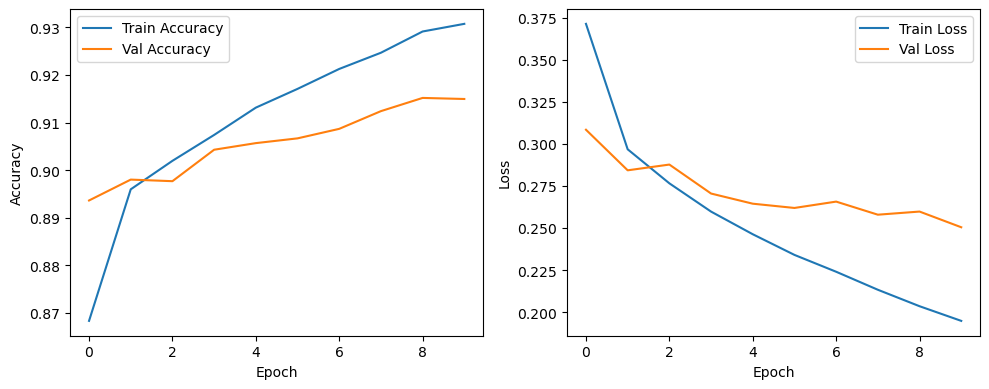

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

Test Accuracy: 0.9194


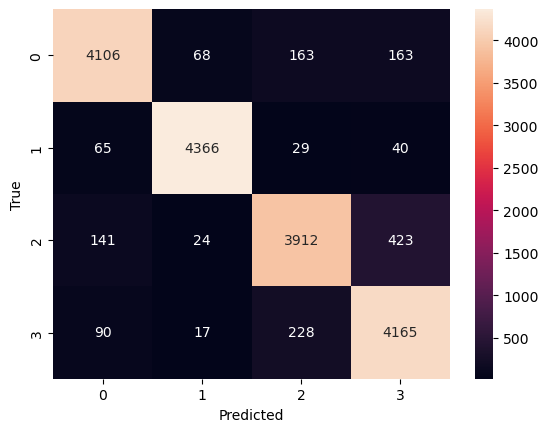

Precision: 0.9202
Recall: 0.9194
F1-Score: 0.9195


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

model.eval()
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Store probabilities for ROC
test_acc = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_acc:.4f}')
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [24]:
torch.save(model.state_dict(), 'huggingface_transformer_model.pt')
print("Model Weights Saved.")

Model Weights Saved.


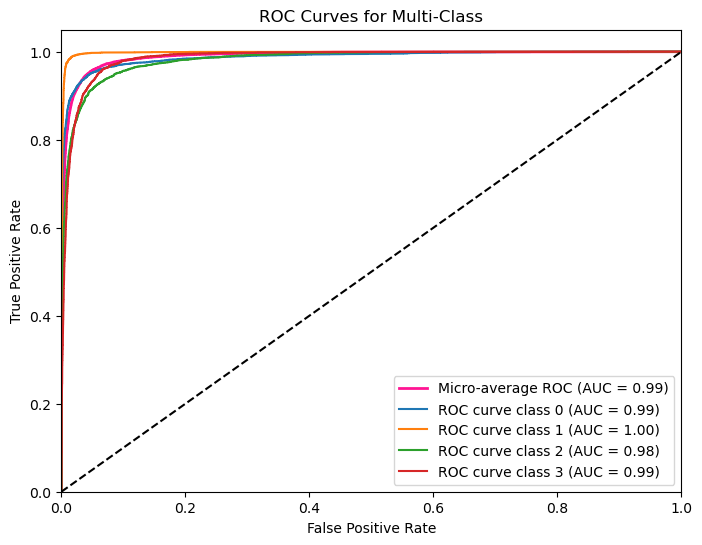

In [28]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize labels for ROC
n_classes = 4
binarized_labels = label_binarize(all_labels, classes=range(n_classes))
all_probs = np.array(all_probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(binarized_labels.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linewidth=2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class')
plt.legend(loc="lower right")
plt.show()

# Comparing the two models

# Results Comparison

## Transformer Classifier (First model: trained for 5 epochs)
- Test Set Results:
- Accuracy : 0.8964
- Precision: 0.8986
- Recall   : 0.8964
- F1 Score : 0.8966

## Transformer Model (Second model: trained for 10 epochs)
- Test Accuracy: 0.9194
- Precision: 0.9202
- Recall: 0.9194
- F1-Score: 0.9195


#### **While both models performed well in terms of accuracy and metrics such as precision, recall, and F1-score, certain factors (or rather, two key aspects) distinguish one as superior. Let’s first compare the pipeline elements—beyond the models themselves—that set them apart, as the architectures of both remain nearly identical.**
---

## Distinguishing characteristics of the two pipelines

### First Model:
Text Preprocessing:
* Cleaning process is kept same for both
* **Whitespace normalization**: Removed unnecessary spaces
* **Tokenization**: Whitespace-based (custom logic)
* **Vocabulary building**: Only kept frequent tokens and added special tokens (`<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`)
* **Numericalization**: Converted tokens to integer indices using the vocabulary

Embedding:
* **Embedding Layer**: nn.Embedding : Converts input token IDs into dense vectors.
* **Positional Encoding**: Adds sequence order information using sinusoidal functions.

### Second Model:
Text Preprocessing
- **Tokenization** : **Hugging Face subword tokenization**, dynamic padding.
- **Vocabulary Building** : Pre-trained, includes special tokens.
- **Numericalization** : Indices via tokenizer, padded sequences.

Emedding
- **Embedding Layer**: **Pre-trained GloVe**, 100D, frozen.
- **Positional Encoding** : Learnable parameter, sequence order.
---
### Adavantages of the strategy used in second model:

- **Superior Tokenization** : Hugging Face subword tokenization (e.g., WordPiece) outperforms traditional whitespace splitting, handling OOV words effectively.
- **Rich Semantic Embeddings** : GloVe embeddings capture co-occurrence stats, outclassing sparse one-hot encodings.
- **Reduced Sparsity** : Combines subword tokens with GloVe, minimizing dimensionality vs. traditional n-grams.
- **Pre-trained Insight**: GloVe injects linguistic knowledge, beating untrained traditional methods.
- **Scalable Efficiency**: Dynamic vocab and padding enhance flexibility over rigid traditional approaches.

### Of course, this comes with its Disadvantages:
- **Computational Overhead** : Hugging Face tokenization and GloVe loading demand more memory and processing than simple methods.
- **Dependency Risk** : Relies on pre-trained resources, vulnerable to updates or unavailability.
- **Over-specialization**: Subword tokenization may overfit to training corpus, unlike versatile traditional splits.
- **Initialization Bias**: GloVe embeddings may introduce pre-trained biases, unlike neutral traditional embeddings.
- **Complexity Increase**: Setup and tuning are more intricate than straightforward traditional approaches.

---

## Conclusion
##### Now, given the capabilities of our devices and overall preprocessing and training time of the two models, the advantages outweigh the disadvantages,allowing us to declare a winner: the second model, utilizing AutoTokenizer (HF) + GloVe.

# References
1. https://huggingface.co/docs/transformers/en/main_classes/tokenizer
2. https://radimrehurek.com/gensim/downloader.html
